# COMP 3610 PROJECT

| GROUP D  |
| ------- |
| `RAUL ALI`   |
| `JOSIAH JOEL`   |
| `DAYANAND MOONOO`   |
| `ZACHARY RAMPERSAD`   |

**NOTES:**
- This notebook uses the [Emotions Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/emotions) from Kaggle which is a collection of English Twitter messages annotated with six perceived fundamental emotional tones: *(0) sadness, (1) joy, (2) love, (3) anger, (4) fear, (5) surprise*
- This is a Multi-class Classification problem involving **Natural Language Processing**.
- We under-sample using the minority class in order to balance our data.
- We will use accuracy as our classifier performance metric.
- We will experiment with 3 classifier models:
    1. **Multi-layer Perceptron** (Artificial Neural Networks)
    2. **Random Forest Classifier**
    3. **Multi-nomial Logistic Regression** (SoftMax Regression)
- 3 Vectorization types will be considered:
    1. Count Vectorization
    2. TF-IDF (Term Frequency - Inverse Document Frequency)
    3. TF-IDF with N-grams
- Once we have determined a suitable model, we will experiment further by validating classification metrics using **K-Fold Cross Validation**.
- We will *demonstrate* how the model will work in the backend of our application at the end of this notebook.

## IMPORTS / READ DATA

In [102]:
# Dataframe / Visualization Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Text Cleaning Imports
import re
#!pip install emoji
import emoji
from bs4 import BeautifulSoup
import string
from string import punctuation
# from itertools import chain

# Vectorization Imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics/ Utilities Imports
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Classification Model Imports
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

# Word Cloud
from wordcloud import WordCloud, STOPWORDS

# Model-Saving Imports
from joblib import dump
from joblib import load

In [103]:
seed_value = 42 # Initialize seed for reproducibility 
k_folds = 10    # Number of folds for cross-validation

# Import data into a data frame
df=pd.read_csv("text.csv", index_col=0)

# Print the last 5 rows to get a general idea of the dataset
df.tail()

,text,label
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3
416808,i think that after i had spent some time inves...,5


Create a map for the perceived emotional tone labels:

In [ ]:
emo_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

## DATA PRE-PROCESSING / CLEANING

We will perform the following steps to refine our corpus of text:
- Removing links from the corpus
- Removing punctuation
- Removing HTML tags
- Removing Emojis
- Covert text to lowercase only
- Removing additional white spaces
- Drop duplicates

In [104]:
def clean_text(text):

    text = ' '.join(text.split()) # Remove additional white spaces
    text = emoji.demojize(text, delimiters=("", "")) # Replace emojis with word representation
    text = re.sub(r'http\S+', '', text) # Remove links
    text = text.translate(str.maketrans('', '', punctuation)) # Remove punctuation
    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text.lower() # Convert all text to lowercase

    return text

In [105]:
# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

# Remove duplicate text
df.drop_duplicates(subset='clean_text', keep='first', inplace=True)

In [106]:
# Drop the original text feature
text_removed = df.pop('text')

# Extract the clean_text column to be moved
move_cleantext = df.pop('clean_text')

# Insert the labels after the clean_text feature column at position 1
df.insert(0, 'clean_text', move_cleantext )

In [108]:
# Run this code to reinsert a refreshed clean_text column
# df.drop(columns=['clean_text'], inplace=True)
# df.insert(0, 'clean_text', move_cleantext )

In [109]:
# Check the number of text samples in each tone category
df['label'].value_counts()

label
1    135030
0    118511
3     54777
4     43629
2     29468
5     12407
Name: count, dtype: int64

### Undersampling

Sample an equal number of all review types using the minority class.
We observe that the minority class is `surprise`.

In [110]:
# shuffle df before sampling
df = shuffle(df, random_state=seed_value)
df.reset_index(drop=True, inplace=True)

# Minority class is Surprise
surp = df[df['label']==5]
print(surp.shape)

(12407, 2)


In [111]:
# Function to Under-sample Classes
def undersampler(df, minority_shape):
    
    a = df[df['label']==0].head(minority_shape)
    b = df[df['label']==1].head(minority_shape)
    c = df[df['label']==2].head(minority_shape)
    d = df[df['label']==3].head(minority_shape)
    e = df[df['label']==4].head(minority_shape)

    return a,b,c,d,e

In [112]:
sad, joy,love, angr , fear = undersampler(df,surp.shape[0])

# save each of the samples in a temp array for further processing
arr = [sad, joy, love, angr, fear, surp]

### Common Word Visualization using WordClouds

In [113]:
def print_cloud(data):
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(data)
    return wordcloud

def print_cloud_categories(arr):    
      i=0
      plt.figure(figsize=(15,20))
      for item in arr:
            item_text = ' '.join(item['clean_text'])
            print (f'There are {len(item_text)} words in the `{emo_map[i]}` Text Sample.')
            wordcloud = print_cloud(item_text)

            plt.subplot(6, 2, i+1)
            plt.imshow(wordcloud , interpolation='bilinear')
            plt.title(f'`{emo_map[i]}` Text Sample')
            plt.axis('off')
            i+=1

      plt.tight_layout()
      plt.show()

There are 1173290 words in the `sadness` Text Sample.


There are 1225595 words in the `joy` Text Sample.
There are 1302690 words in the `love` Text Sample.
There are 1200728 words in the `anger` Text Sample.
There are 1219214 words in the `fear` Text Sample.
There are 1256769 words in the `surprise` Text Sample.


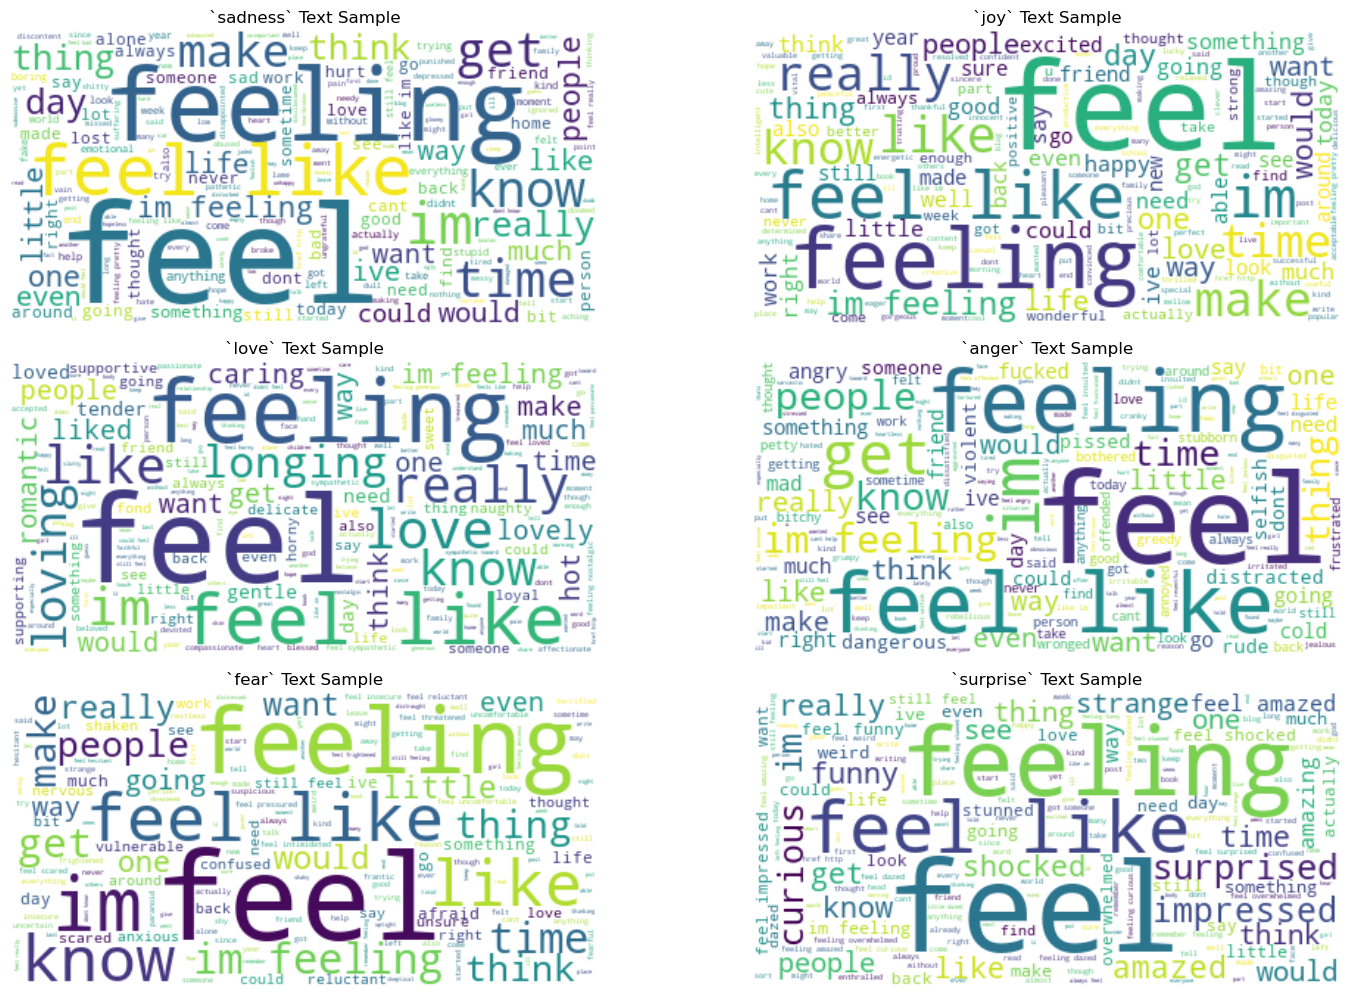

In [114]:
print_cloud_categories(arr)

### Common Word Extraction using Word Counts

From the word clouds above, we observe that there seems to be similar words overlapping between classes. <br>
These words `feel`, `feeling`, etc. are noise in our data. <br>
We will check the word counts of the top words in each our samples and clean these words out of our data-frame.  <br>
Finally, we will rerun the under-sample from the cleaned data-frame. <br>

In [115]:
def print_top_words(arr,vectorizer):
    i=0
    for item in arr:
        item_vect = vectorizer.fit_transform(item['clean_text'])

        item_words = vectorizer.get_feature_names_out()
        word_counts = item_vect.toarray().sum(axis=0)
        
        # Create a dictionary to store word counts
        word_count_dict = dict(zip(item_words, word_counts))

        # Sort the dictionary by counts in descending order
        sorted_word_counts = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)

        print(f'Top Words in `{emo_map[i]}` Text Sample:')
        j=1
        for word, count in sorted_word_counts[:10]:
            print(f'({j}). {word} : {count}' )
            j+=1
        print('\n')
        i+=1

In [116]:
# Count Vectorizer
countv = CountVectorizer(stop_words = 'english')

print_top_words(arr,countv)

Top Words in `sadness` Text Sample:
(1). feel : 8551
(2). feeling : 4189
(3). like : 2260
(4). im : 1762
(5). just : 1197
(6). really : 747
(7). know : 726
(8). time : 635
(9). little : 572
(10). ive : 541


Top Words in `joy` Text Sample:
(1). feel : 9014
(2). feeling : 3625
(3). like : 2147
(4). im : 1794
(5). just : 928
(6). really : 718
(7). know : 634
(8). time : 633
(9). make : 506
(10). people : 464


Top Words in `love` Text Sample:
(1). feel : 8676
(2). feeling : 3771
(3). like : 2717
(4). im : 1728
(5). just : 1034
(6). love : 871
(7). really : 840
(8). know : 742
(9). loved : 702
(10). loving : 695


Top Words in `anger` Text Sample:
(1). feel : 8227
(2). feeling : 4052
(3). like : 2207
(4). im : 2033
(5). just : 1226
(6). really : 834
(7). know : 729
(8). people : 710
(9). time : 627
(10). little : 620


Top Words in `fear` Text Sample:
(1). feel : 7910
(2). feeling : 4708
(3). im : 2032
(4). like : 1586
(5). just : 982
(6). little : 913
(7). know : 798
(8). really : 761
(9

### Removing Common Words amongst classes to reduce noise in prediction

Observe that the words: `feel`, `feeling`, `like` and `im` are the top 4 words common amongst all classes and have similar wordcounts within each class. <br>

In [117]:
# Define common words to be removed
words_to_remove = ['feeling', 'feel', 'like', 'im']

In [118]:
# Function to remove specified words from a text
def remove_word_from_string(word, string):

    # Construct a regular expression pattern to match the word
    pattern = r'\b{}\b'.format(re.escape(word))

    # Use re.sub() to replace the matched word with an empty string
    return re.sub(pattern, '', string)


# Function to cycle through all words to remove
def remove_words(text):
    
    for word in words_to_remove:
        text = remove_word_from_string(word, text)

    return text

# Apply the function to the 'clean_text' column
df['clean_text'] = df['clean_text'].apply(remove_words)

In [119]:
# Sample a equal number of all review types using the minority class
surp = df[df['label']==5]
sad, joy,love, angr , fear = undersampler(df,surp.shape[0])

arr = [sad, joy, love, angr, fear, surp]

# Double check top words
print_top_words(arr,countv)

Top Words in `sadness` Text Sample:
(1). just : 1197
(2). really : 747
(3). know : 726
(4). time : 635
(5). little : 572
(6). ive : 541
(7). people : 516
(8). think : 500
(9). want : 447
(10). dont : 441


Top Words in `joy` Text Sample:
(1). just : 928
(2). really : 718
(3). know : 634
(4). time : 633
(5). make : 506
(6). people : 464
(7). love : 441
(8). life : 437
(9). want : 435
(10). pretty : 405


Top Words in `love` Text Sample:
(1). just : 1034
(2). love : 871
(3). really : 840
(4). know : 742
(5). loved : 702
(6). loving : 695
(7). hot : 665
(8). longing : 626
(9). sympathetic : 621
(10). liked : 608


Top Words in `anger` Text Sample:
(1). just : 1226
(2). really : 834
(3). know : 729
(4). people : 710
(5). time : 627
(6). little : 620
(7). want : 566
(8). angry : 529
(9). think : 529
(10). dont : 477


Top Words in `fear` Text Sample:
(1). just : 982
(2). little : 913
(3). know : 798
(4). really : 761
(5). time : 628
(6). bit : 601
(7). people : 544
(8). want : 532
(9). scar

There are 1097199 words in the `sadness` Text Sample.
There are 1151988 words in the `joy` Text Sample.
There are 1227265 words in the `love` Text Sample.
There are 1126562 words in the `anger` Text Sample.
There are 1144210 words in the `fear` Text Sample.
There are 1182381 words in the `surprise` Text Sample.


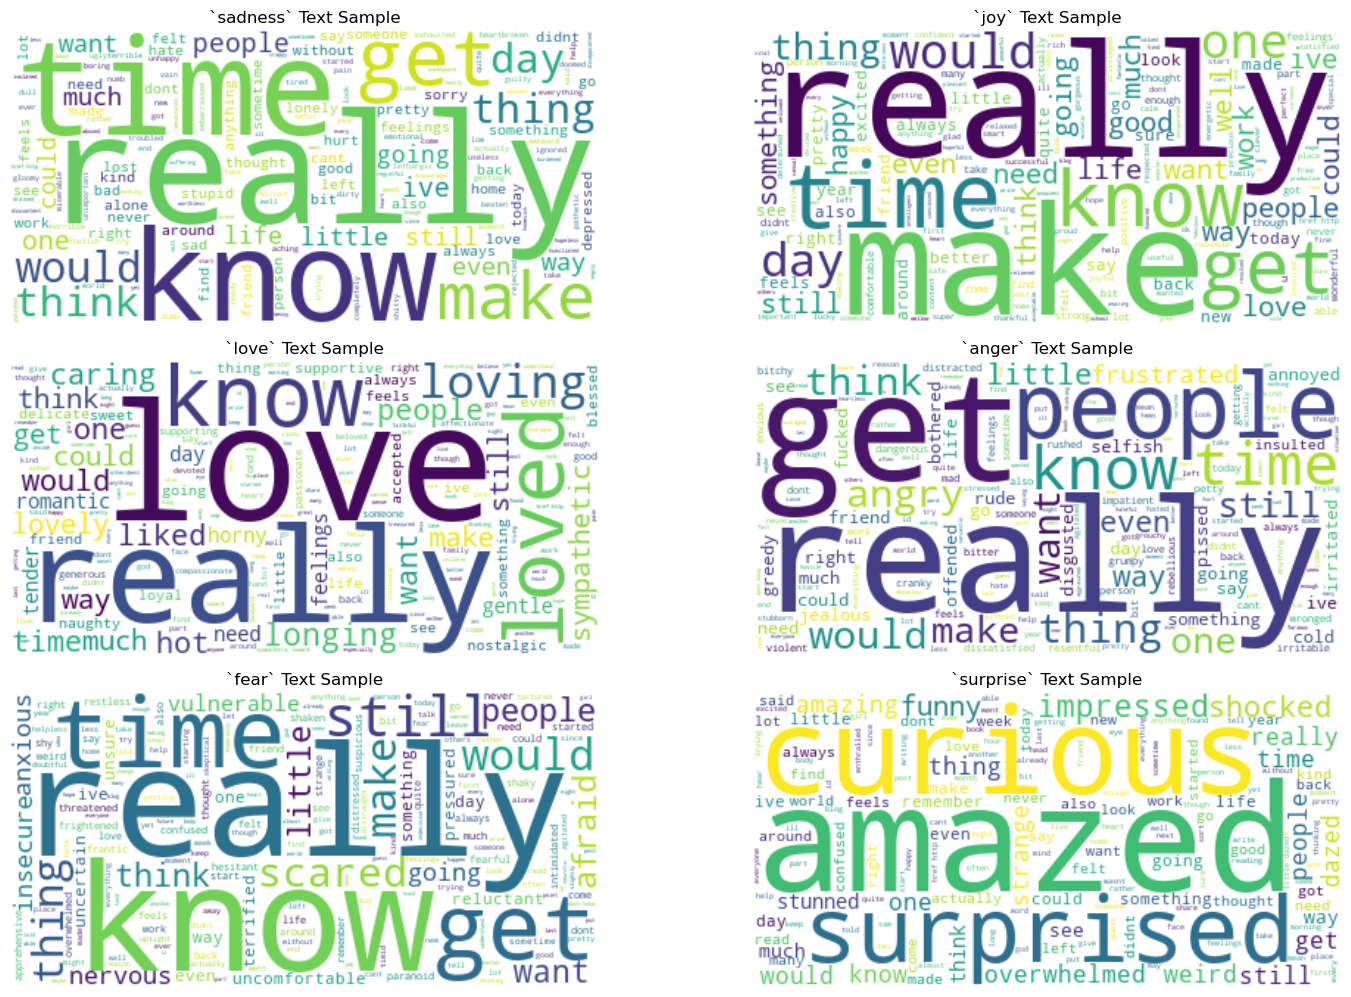

In [120]:
# Double check word clouds
print_cloud_categories(arr)

In [121]:
# Concat all Samples into one df
df_sample = pd.concat([sad,joy,love,angr,fear,surp])

# Shuffle sample df
df_sample = shuffle(df_sample , random_state=seed_value)
df_sample.reset_index(drop=True, inplace=True)

In [122]:
# Assign the clean_text field to X and the labels to y
X = df_sample['clean_text']
y = df_sample['label'].values
print(X.shape)

(74442,)


In [21]:
# Output cleaned dataframe to csv
# df.to_csv('text_cleaned.csv', index=False)

## CLASSIFICATION EXPERIMENTS

### Accuracy Scores 

We will use the `Accuracy` classification metric to compare our models.
For a Binary Prediction problem, accuracy is defined as follows:<br><br> 
$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}​ $ <br>

where:
- True Positives $ TP $ - model correctly predicts the positive class.
- True Negatives $ TN $ -  model correctly predicts the negative class.
- False Positives $ FP $ - model incorrectly predicts the positive class (it predicts positive when the actual class is negative).
- False Negatives $ FN $ -  model incorrectly predicts the negative class (it predicts negative when the actual class is positive).

However, our problem involves multiple classes, thus we define accuracy as:

$ \text{Accuracy} = \frac{\sum_{i=1}^{N} TP_i}{\text{Total Number of Predictions}} $ <br>

where:
- $ N $ is the total number of classes.
- $ TP_i​ $ denotes the number of true positives for class i.

In [30]:
# Arrays to store Accuracy results for each Classifier Model
acc_mlp = np.zeros(3)
acc_randf = np.zeros(3)
acc_logreg = np.zeros(3)

### Vectorization

We must vectorize the corpus of text, converting each document in the corpus into a numerical representation that can be used for machine learning tasks. 

In [31]:
# Count Vectorizer
countv = CountVectorizer(stop_words = 'english')

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words = 'english')

# TF-IDF Vectorizer with ngrams
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')

The function `text_fit_saver` has parameters:
- `X`: training set.
- `y`: test set.
- `vectr`: vectorizer type to be used.
- `clf`: classification model to be used.
- `return_model`: boolean variable to return the model
- `clf_details`: boolean variable that will show classification reports and confusion matrix.

If `return_model` is true, the function will return:

- `vectr`: the trained vectorizer.
- `clf`: the trained classification model.

The function will always return the accuracy score.
- `acc`: accuracy score of the trained model.

To reduce the complexity of the back-end of our application , SelectPercentile will not be used to trim the corpus prior to processing. <br>

In [28]:
def text_fit_saver(X, y, vectr, clf, return_model=False, clf_details=True):
    X_transformed = vectr.fit_transform(X)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=seed_value)
        
    clf.fit(X_train, y_train)

    # Predict labels on the test set
    y_pred = clf.predict(X_test)

    if(clf_details):
        print('# features in X: {}'.format(X_transformed.shape[1]))
        
        print('\nClassification Report:')
        cr = classification_report(y_test, y_pred)
        print (cr)
        
        # Generate confusion matrix
        confmat = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=clf.classes_)
        disp.plot(values_format="0.0f", cmap='PuBu')
        
    acc = accuracy_score(y_test, y_pred)
    acc = round(acc*100,5)
    print(f'\nAccuracy Score: {acc:.3f} %')

    if(return_model):
        return  acc, vectr, clf
    
    return acc

### ARTIFICIAL NEURAL NETWORKS

The Multi-layer Perceptron (MLP) is a type of artificial neural network consisting of multiple layers of neurons. 
The neurons in the MLP typically use nonlinear activation functions, allowing the network to learn complex patterns in data. It is a supervised learning algorithm since the target variable is known.

In [34]:
mlpclf = MLPClassifier(hidden_layer_sizes= (32,) , random_state=seed_value) 

For the MLP, we changed the default hyper-parameters, setting `hidden_layer_sizes` to 1 layer of 32 neurons in order to keep run-time down and saved model size down. 

In [36]:
acc_mlp[0] = text_fit_saver(X, y, countv, mlpclf, return_model=False, clf_details=False)
# runtime = 10 mins


Accuracy Score: 89.690 %


# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2502
           1       0.85      0.88      0.87      2407
           2       0.93      0.90      0.91      2398
           3       0.91      0.90      0.91      2571
           4       0.88      0.87      0.87      2506
           5       0.93      0.92      0.93      2505

    accuracy                           0.90     14889
   macro avg       0.90      0.90      0.90     14889
weighted avg       0.90      0.90      0.90     14889


Accuracy Score: 89.590 %


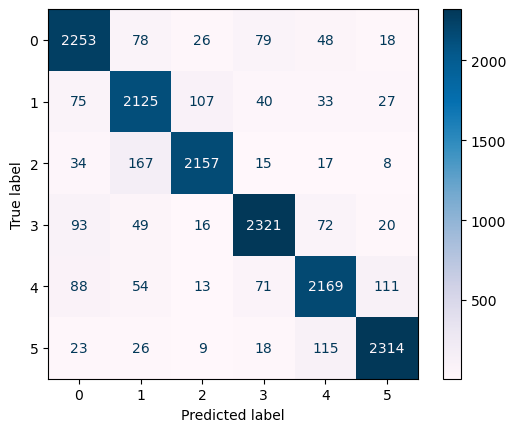

In [121]:
acc_mlp[1] , tfidf_for_mlp, mlp_tfidf = text_fit_saver(X, y, tfidf, mlpclf, return_model=True)
# runtime = 10 mins

In [122]:
# Save trained models using joblib
dump(mlp_tfidf, 'mlp_tfidf.joblib')
dump(tfidf_for_mlp, 'tfidf_for_mlp.joblib')

['tfidf_for_mlp.joblib']

# features in X: 376348

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2502
           1       0.90      0.92      0.91      2407
           2       0.94      0.94      0.94      2398
           3       0.94      0.94      0.94      2571
           4       0.92      0.90      0.91      2506
           5       0.94      0.95      0.94      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 92.666


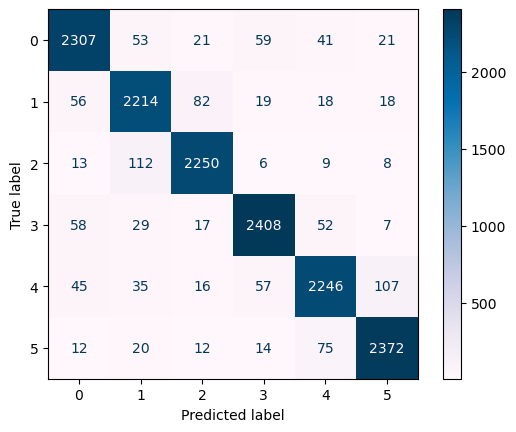

In [36]:
acc_mlp[2] = text_fit_saver(X, y, tfidf_n, mlpclf)
# runtime = 50 mins

The inclusion of n-grams (bi-grams) exponentially increased the complexity of the model and as a result, the computing time required to build the model increased . <br>
There is a marginal increase in accuracy of 3% using tf-idf with n-grams (92.6%) compared to tf-idf (89.6%) under the MLP classifier. <br>
In the interest of reducing the complexity of the back-end of our application we will only save the MLP with the tf-idf model and vectorizer for experimentation.

### RANDOM FOREST

Random forests are another example of supervised machine learning algorithms. It creates multiple decision trees using different random subsets of the data and features. Each decision tree will give its own result on the classification of the data. Predictions are made by taking the most popular result from all the predictions of each decision tree.

In [33]:
randforest = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=seed_value)

Random Forest models are known to be large since they are an ensemble method which combine predictions from multiple models.
We will use the default hyper-parameters of the Random Forest (`n_estimators=100` and `max_depth=None`).

In [35]:
acc_randf[0] = text_fit_saver(X, y, countv, randforest, return_model=False, clf_details=False)
# Runtime = 5 mins


Accuracy Score: 92.934 %


# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      2502
           1       0.96      0.89      0.92      2407
           2       0.92      0.98      0.95      2398
           3       0.93      0.94      0.93      2571
           4       0.93      0.90      0.92      2506
           5       0.92      0.98      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 93.263


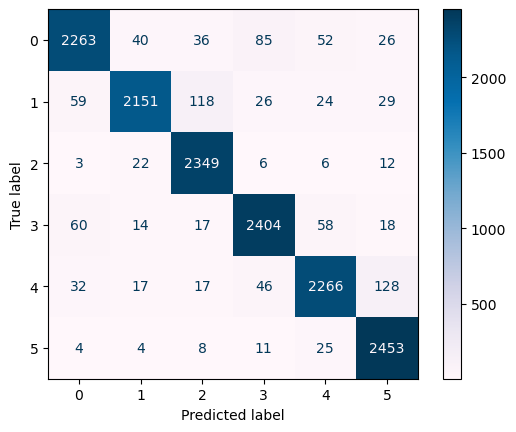

In [84]:
acc_randf[1] , tfidf_for_randf, randf_tfidf = text_fit_saver(X, y, tfidf, randforest, return_model=True)
# runtime = 5 mins

In [ ]:
# Save trained models using joblib
dump(randf_tfidf, 'randf_tfidf.joblib')
dump(tfidf_for_randf, 'tfidf_for_randf.joblib')

# features in X: 376348

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2502
           1       0.94      0.90      0.92      2407
           2       0.93      0.97      0.95      2398
           3       0.94      0.93      0.93      2571
           4       0.94      0.90      0.92      2506
           5       0.92      0.98      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 93.129


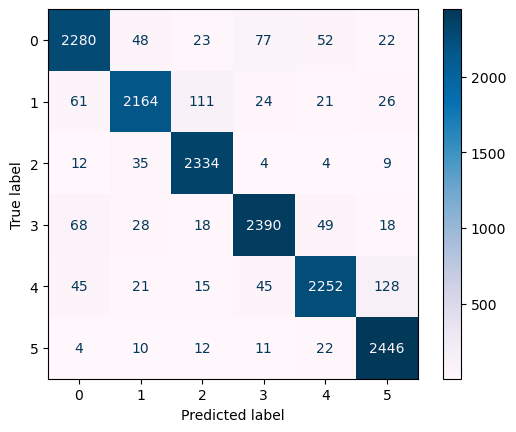

In [40]:
acc_randf[2] = text_fit_saver(X, y, tfidf_n, randforest)
# runtime = 60 mins

The Random Forest Classifier performs well in accuracy score for all vectorizers.<br> 
There is a marginal decrease in accuracy score using tf-idf with n-grams (93.13%) when compared to tf-idf only (93.26%). <br> 
However, tf-idf with n-grams took considerably longer to build (60 mins). <br>

As mentioned before, Random Forest Classification models are typically very large. In our case, the saved `randf_tfidf.joblib` was 366mb which cannot be hosted on GitHub. Other experiments of changing the hyper-parameters lead to file sizes larger than 25mb (GitHub limit) while sacrificing accuracy score. 

As a result, Random Forest will not be used in our backend for the application. We will use it as a benchmark of the theoretical peak performance of our classifiers.

### MULTINOMIAL LOGISTIC REGRESSION (SOFTMAX)

Multi-nomial Logistic Regression (SoftMax) is a supervised learning classification algorithm used to assign observations to multiple classes. 
It is an extension of logistic regression in which the target variable is binary (two categories). 

In [23]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)

In [32]:
acc_logreg[0] = text_fit_saver(X, y, countv, logreg, return_model=False, clf_details=False)


Accuracy Score: 93.183 %


# features in X: 33431

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2502
           1       0.91      0.91      0.91      2407
           2       0.93      0.96      0.95      2398
           3       0.94      0.93      0.93      2571
           4       0.93      0.90      0.91      2506
           5       0.93      0.97      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 93.022 %


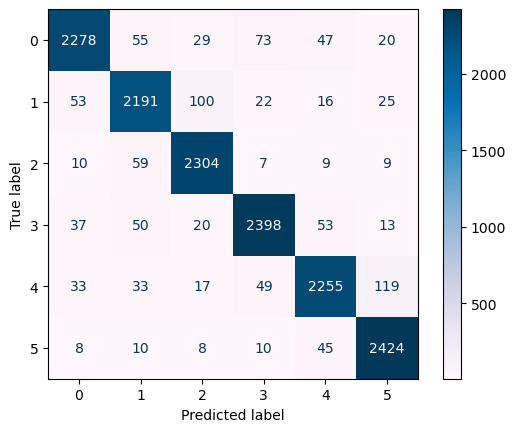

In [123]:
acc_logreg[1], tfidf_for_logreg , logreg_tfidf = text_fit_saver(X, y, tfidf, logreg, return_model=True)

In [124]:
# Save trained models using joblib
dump(logreg_tfidf, 'logreg_tfidf.joblib')
dump(tfidf_for_logreg, 'tfidf_for_logreg.joblib')

['tfidf_for_logreg.joblib']

# features in X: 376348

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      2502
           1       0.90      0.91      0.90      2407
           2       0.93      0.96      0.94      2398
           3       0.94      0.93      0.93      2571
           4       0.93      0.89      0.91      2506
           5       0.93      0.97      0.95      2505

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889


Accuracy Score: 92.746 %


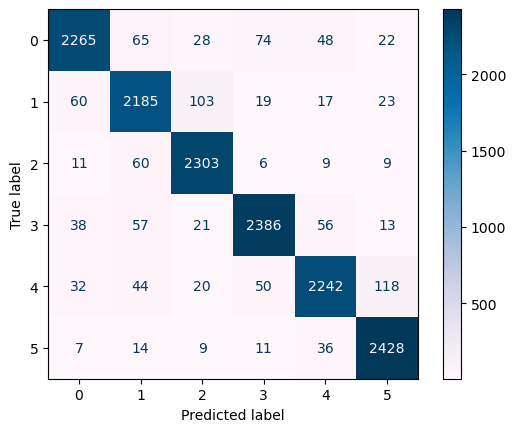

In [37]:
acc_logreg[2],tfidf_for_logreg_ng , logreg_tfidf_ng = text_fit_saver(X, y, tfidf_n, logreg, return_model=True)
# runtime = 1 min

In [38]:
# Save trained models using joblib
dump(logreg_tfidf_ng, 'logreg_tfidf_ng.joblib')
dump(tfidf_for_logreg_ng, 'tfidf_for_logreg_ng.joblib')

['tfidf_for_logreg_ng.joblib']

All implementations of the multi-nomial logistic regression classifier performed well in both accuracy score and had the fastest building runtime of all the models. We will save the both tf-idf and tf-idf with n-grams (bi-grams) versions of this model for further experimentation in the backend of our application.

In [48]:
# Store the Accuracy scores in a Data-frame
df_acc = pd.DataFrame({
    'Vectorizer Type' : ['Count','TF_IDF','TF_IDF_Ngrams'],
    'MLP' : acc_mlp,
    'Random_Forest' : acc_randf,
    'Log_Reg': acc_logreg
})

# Show the Data-frame
df_acc = df_acc.set_index('Vectorizer Type')
df_acc 

,MLP,Random_Forest,Log_Reg
Vectorizer Type,,,
Count,89.69038,92.93438,93.18289
TF_IDF,89.58963,93.26348,93.02169
TF_IDF_Ngrams,92.66573,93.12916,92.74632


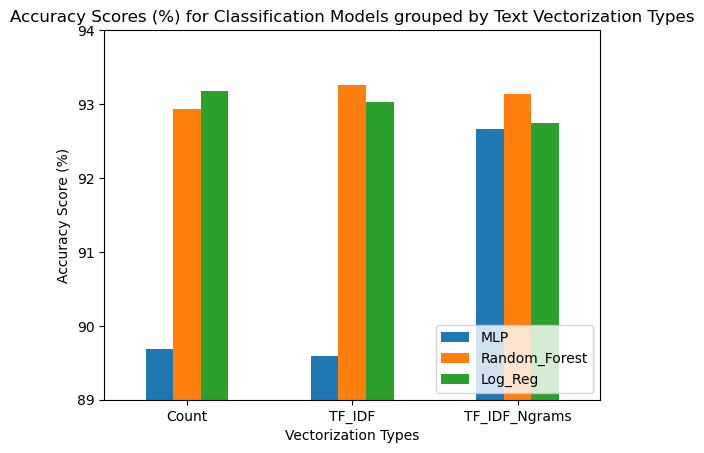

In [73]:
df_acc.plot(kind='bar', legend=True)
plt.title('Accuracy Scores (%) for Classification Models grouped by Text Vectorization Types')
plt.xlabel('Vectorization Types')
plt.xticks(rotation=0)
plt.ylabel('Accuracy Score (%)')
plt.ylim(89, 94)  # Set y-axis limits
plt.legend(loc='lower right') 
plt.show()

In [55]:
# Calculate the average score for each classifier model
avg_acc_scores = df_acc.mean(axis=0)

# Print the average scores for each trail
for model, avg_acc in avg_acc_scores.items():
    print(f"Average accuracy for {model}: {avg_acc:.3f} %")

Average accuracy for MLP: 90.649 %
Average accuracy for Random_Forest: 93.109 %
Average accuracy for Log_Reg: 92.984 %


`Note:` The y-axis limits were truncated such that we can better see the differences in accuracy scores, since all were greater than 89%. <br>

Generally, all models performed well, obtaining accuracy scores around 93%. The only exception was the Multi-layer Perceptron (MLP) for count vectorization (countv) and tf-idf. The MLP is capable of capturing non-linear relationships between variables. It is possible that in this dataset, the complexity of the MLP is causing over-fitting, resulting in higher mis-classification rates. However, under tf-idf with bi-grams, the MLP performed comparably to the other models. It must be noted that tf-idf with n-grams (bi-grams), lead to increased complexity and extremely long building run-times for both the MLP and Random forest.     

As aforementioned, the Random Forest Classifier will function as a benchmark for peak performance to compare our other models. 
It is the best, most consistently performing model, and it scored 93.26% for tf-idf which was the highest overall observed accuracy score.

On average Multi-nomial Logistic Regression (SoftMax) performed on par with the Random Forest Classifier.
Under countv, the SoftMax Regression performed the best in accuracy score and there was only a marginal difference between it an Random Forest for tf-idf only and with n-grams.

## VALIDATION

In this section we will validate the results of the most suitable model, `SoftMax Regression` by performing K-Fold Cross Validation (CV) for k=10.
- We will validate the accuracy score of the SoftMax model.
- We will validate the saved SoftMax model.

The function `text_fit_kfolds` serves 2 purposes:
1. Validate Classification Metrics
2. Validate Trained Models

Input parameters:
- `X_origin`: training set.
- `y`: test set.
- `vectr`: vectorizer type to be used.
- `clf`: classification model to be used.
- `fit`: boolean variable to fit new model on each iteration (for validation of metrics)
- `conf_mat_show`: boolean variable that will show the confusion matrix.
- `clf_rep_show`: boolean variable that will show classification reports.

The function will return the average accuracy score.
- `avg_acc`: accuracy score calculated by averaging over each fold.

In [41]:
def text_fit_kfolds(X_origin, y, vectr, clf, fit=True, conf_mat_show= True, clf_rep_show=False):

    if(fit):  
        X = vectr.fit_transform(X_origin) # fit the vectorizer for Metric Validation
    else:
        X = vectr.transform(X_origin) # Use loaded vectorizer for Model Validation

    k_fold = KFold(n_splits=k_folds)
    confmat = np.zeros((6, 6)) # Confusion Matrix
    classification_reports =[] 
    acc_list=[]
    
    for train_idx, test_idx in k_fold.split(X):  #split generates indices to split data into training and test set.
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if(fit):
            clf.fit(X_train, y_train) # fit the model on each iteration for Metric Validation
        
        # Use loaded Classifier for Model Validation 
        y_pred = clf.predict(X_test)

        confmat += confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        acc_list.append(accuracy_score(y_test, y_pred))
        classification_reports.append(report)

    avg_acc = np.mean(acc_list)
    avg_acc = round(avg_acc *100,5)
    print(f'\nAvg Accuracy Score: {avg_acc:.3f} %')

    if(conf_mat_show):
        disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=clf.classes_)
        disp.plot(values_format="0.0f", cmap='PuBu')

    if(clf_rep_show):
        print('\nClassification Reports:')
        for fold_idx, report in enumerate(classification_reports):
            print('Classification Report for fold', fold_idx + 1, ':')
            print(report)
    
    return avg_acc

### Validate the Accuracy Scores for any SoftMax model

In [ ]:
acc_logreg_k = np.zeros(2)


Avg Accuracy Score: 92.972 %


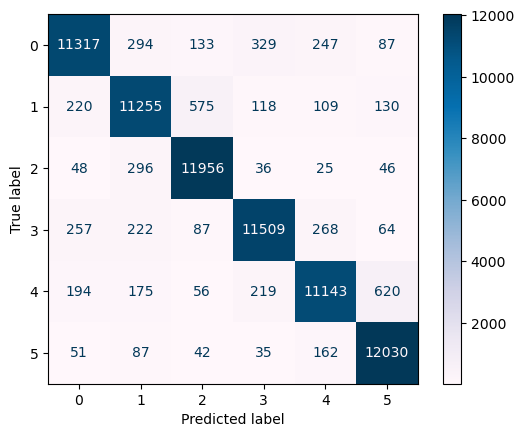

In [25]:
acc_logreg_k[0]= text_fit_kfolds(X, y, tfidf, logreg, fit=True)
# runtime = 1 min


Avg Accuracy Score: 92.711 %


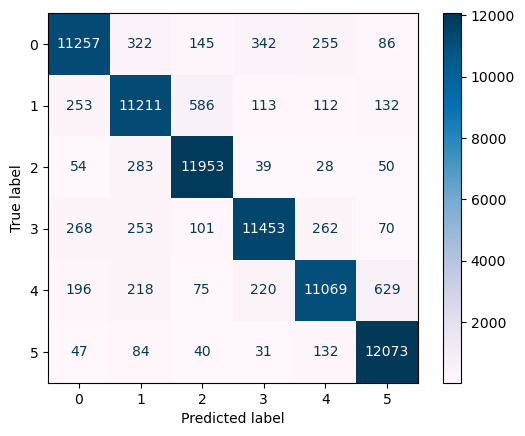

In [26]:
acc_logreg_k[1]= text_fit_kfolds(X, y, tfidf_n, logreg, fit=True)
# runtime = 7 mins

### Validate the saved SoftMax models

Now, we validate our models  which we created with an initial train-test split of 80-20 by running each of them with k-fold cross-validation (CV) on the `whole imbalanced` dataset after training.

1. **Improving Generalization & Mitigating Overfitting**: The initial train-test split helps in assessing the model's performance on unseen data. CV provides a more robust estimate of the model's 'real-world' performance by repeatedly splitting the data into different training and validation sets.

2. **Better Utilization of Data**: By using CV on the entire dataset, we make more efficient use of the available data. Every data point gets a chance to be part of both the training and validation sets, contributing to a more reliable evaluation of the model's performance.

3. **Assessment of Variance**: assess the variability of the model's performance metrics across different folds. This provides insights into how stable the model is and helps in estimating confidence intervals for performance metrics.

Overall, using k-fold cross-validation after an initial train-test split enhances the reliability and robustness of the model evaluation process, leading to more confident model selection and deployment decisions.

In [51]:
# Extract the whole corpus of text from the data-frame
# For these experiments, we are purposely using the whole imbalanced dataset
X_all = df['clean_text']
y_all = df['label'].values


Avg Accuracy Score: 92.064 %


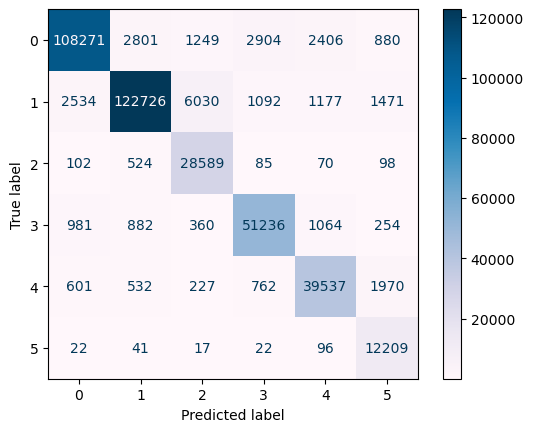

In [52]:
# Load the saved tf-idf models
loaded_model = load('logreg_tfidf.joblib')
loaded_vectr = load('tfidf_for_logreg.joblib')

acc_logreg_saved_k = np.zeros(2)

acc_logreg_saved_k[0]= text_fit_kfolds(X_all, y_all, loaded_vectr, loaded_model, fit=False)


Avg Accuracy Score: 91.842 %


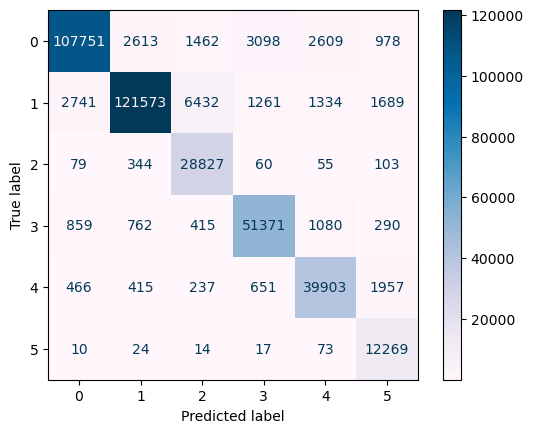

In [65]:
# Load the saved tf-idf with n-grams models
loaded_model = load('logreg_tfidf_ng.joblib')
loaded_vectr = load('tfidf_for_logreg_ng.joblib')

acc_logreg_saved_k[1]= text_fit_kfolds(X_all, y_all, loaded_vectr, loaded_model, fit=False)

In [61]:
# Store the Validated Accuracy scores in a Data-frame
df_acc_k = pd.DataFrame({
    'Vectorizer Type' : ['TF_IDF','TF_IDF_Ngrams'],
    'SoftMax (Balanced Data)' : acc_logreg_k,
    'Saved SoftMax (Imbalanced Data)' : acc_logreg_saved_k,
})

# Show the Data-frame
df_acc_k = df_acc_k.set_index('Vectorizer Type')
df_acc_k 

,SoftMax (Balanced Data),Saved SoftMax (Imbalanced Data)
Vectorizer Type,,
TF_IDF,92.97171,92.06392
TF_IDF_Ngrams,92.71110,91.84199


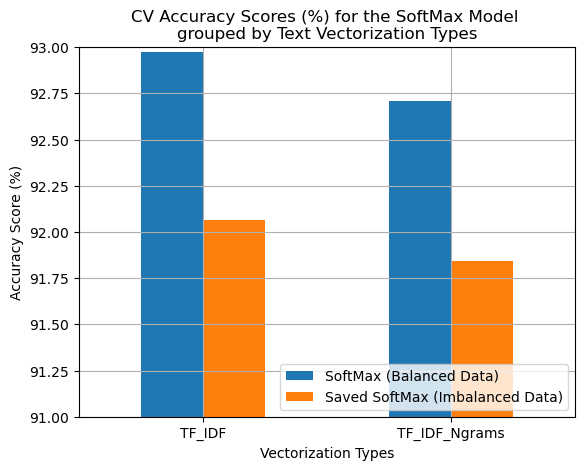

In [64]:
df_acc_k.plot(kind='bar', legend=True)
plt.title('CV Accuracy Scores (%) for the SoftMax Model \ngrouped by Text Vectorization Types')
plt.xlabel('Vectorization Types')
plt.xticks(rotation=0)
plt.ylabel('Accuracy Score (%)')
plt.ylim(91, 93)  # Set y-axis limits
plt.legend(loc='lower right') 
plt.grid()
plt.show()

`Note:` The y-axis limits were truncated such that we can better see the differences in accuracy scores, since all were greater than 91%. <br>

This bar chart compares the average accuracy for a SoftMax model on balanced data and the average accuracy of our SoftMax model on unbalanced, unseen data. It gives insight into the theoretical performance (under the 'best' conditions) as compared to the 'real' performance of the model.

From the above results, the CV average accuracy of the SoftMax model is approx. 93% for tf-idf and 92.7% tf-idf with n-grams, i.e. whenever we create a SoftMax model using a balanced sample from the dataset, we expect an accuracy of approx. 93%.

When using CV to validate our saved model with the whole dataset (not just the balanced sample), we still saw an impressive 92% accuracy under tf-idf and 91.8% for tf-idf with n-grams. Since the model performs well on average across all folds, it suggests that it will generalize well to unseen data, especially for our application.

## DEMONSTRATION

### Obtain the probabilities of classification for any instance in df

For this demonstration, we will continue to use the trained Multi-nomial Logistic (SoftMax) Regression classifier with tf-idf and n-grams (bi-grams).

The function `process_input_to_probs` has parameters:
- `text`: input text to be cleaned.
- `loaded_vectr`: vectorizer type to be used.
- `loaded_model`: classification model to be used.

The function will return:
- `probs_dict`: a dictionary containing the probabilities of being in each class.

In [66]:
# Function to process text and generate probabilities
def process_input_to_probs(text,loaded_vectr,loaded_model):
    
    text = ' '.join(text.split())   # Remove additional white spaces
    text = emoji.demojize(text, delimiters=("", "")) # Replace emojis with word representation
    text = re.sub(r'http\S+', '', text) # Remove links
    text = text.translate(str.maketrans('', '', punctuation)) # Remove punctuation
    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text.lower() # Convert all text to lowercase
    
    words_to_remove = ['feeling', 'feel', 'like', 'im'] # Remove common words
    for word in words_to_remove:
            pattern = r'\b{}\b'.format(re.escape(word))
            text = re.sub(pattern, '', text)
    
    text_trans = loaded_vectr.transform([text])
    pred_probs = loaded_model.predict_proba(text_trans)

    labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

    # Create a dictionary to store the probabilities with labels
    probs_dict = {}

    # Iterate over the probabilities array and labels simultaneously
    for label, prob in zip(labels, pred_probs[0]):
        probs_dict[label] = round(prob*100,5)

    print(probs_dict)

    return probs_dict

In [67]:
# Take a random instance from df
r_num = random.randint(0, len(df))
X_inst = df.at[r_num, 'clean_text']  
y_inst = df.at[r_num, 'label']  

print(f'({r_num}). Class {y_inst} : {X_inst} \n')

probs = process_input_to_probs(X_inst,loaded_vectr,loaded_model)

(199272). Class 0 : i went to a show tonight and had a blast but still came out of the night  disillusioned with the state of music in general 

{'sadness': 66.4683, 'joy': 5.84754, 'love': 5.43728, 'anger': 8.37746, 'fear': 7.3147, 'surprise': 6.55472}


## CONCLUSIONS

- Based on all of the experiments carried out above, we will implement the **SoftMax Regression Model with tf-idf and n-grams (bi-grams)** into the backend of our `Text Classification Application`. Even though we want to maximize accuracy we are willing to take the marginal (0.2%) accuracy trade-off from tf-idf only such that our model deals with the majority classes of `sadness` and `joy` in a less biased fashion.
- It was recognized that Random Forest performed the best due to its ability to take the best prediction from multiple models. 
- Multi-layer Perceptron performed poorly since its ability to capture non-linear relationships may be causing overfitting, capturing too much noise in the data.